In [1]:
# lets start with importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# lets read the dataset
df = pd.read_csv('C:/Users/BatuhanYILMAZ/Desktop/staj/project_1/datasets/preprocessed_winszorization_without_duration.csv')
df.head()

,age,balance,day,campaign,job,month,marital_divorced,marital_married,marital_single,education_primary,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,27,-172,3,1,4,8,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,27,-172,3,1,9,8,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,27,-172,3,1,2,8,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,27,-172,3,1,1,8,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
4,27,-172,3,1,11,8,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [3]:
# lets divide the dataset into independent-dependent variables
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

In [4]:
# split the dataset into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Now, lets start by undersampling the dataset with 0.5 ratio and 1 ratio to evaluate both cases.

rus_1 = RandomUnderSampler(sampling_strategy=1, random_state=42)  # roughly a 1:1 ratio of class 0 to class 1 instances
X_train_under_sampled_1, y_train_under_sampled_1 = rus_1.fit_resample(X_train, y_train)
# Count the number of instances of each class after undersampling
print("Class 0 count:", len(X_train_under_sampled_1[y_train_under_sampled_1 == 0]))
print("Class 1 count:", len(y_train_under_sampled_1[y_train_under_sampled_1 == 1]))

Class 0 count: 4198
Class 1 count: 4198


In [6]:
# lets create the model and fit it with grid-search approach. for grid-search evaluation metric, recall will be used as it
# is the ratio of correctly predicted positive observations (true positives) to the total actual positives 
# (true positives + false negatives), which is suitable for an imbalanced dataset.
logreg = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],     
    'penalty': ['l1','l2'],                  
    'solver': ['liblinear'],   
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    logreg,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the undersampled data
grid_search.fit(X_train_under_sampled_1, y_train_under_sampled_1)

# Get the best estimator from the grid search
best_model_log_reg_under_sample = grid_search.best_estimator_
best_param_log_reg_under_sample = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val = cross_val_recall_scores.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred = best_model_log_reg_under_sample.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_param_log_reg_under_sample)
print("Average Recall from Cross-Validation:", avg_recall_cross_val)

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Average Recall from Cross-Validation: 0.6872416141665247
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      7952
           1       0.19      0.67      0.30      1091

    accuracy                           0.63      9043
   macro avg       0.56      0.65      0.52      9043
weighted avg       0.84      0.63      0.69      9043



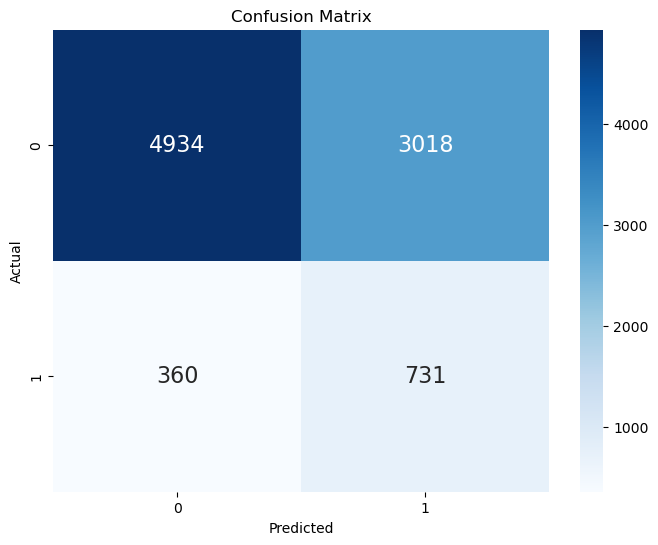

In [7]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

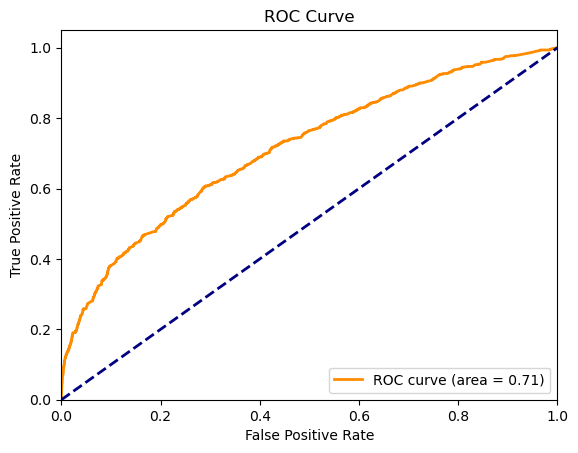

In [8]:
# lets see the ROC curve to see the model's performance at varying levels of discrimination.
y_prob = best_model_log_reg_under_sample.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

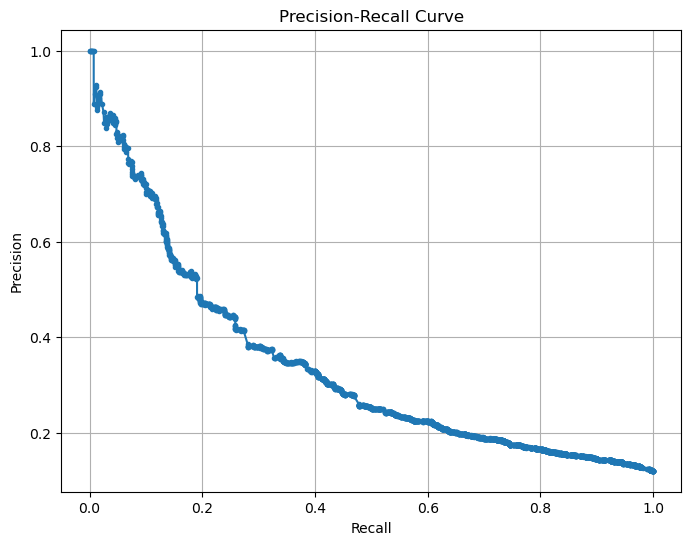

In [9]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_log_reg_under_sample.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

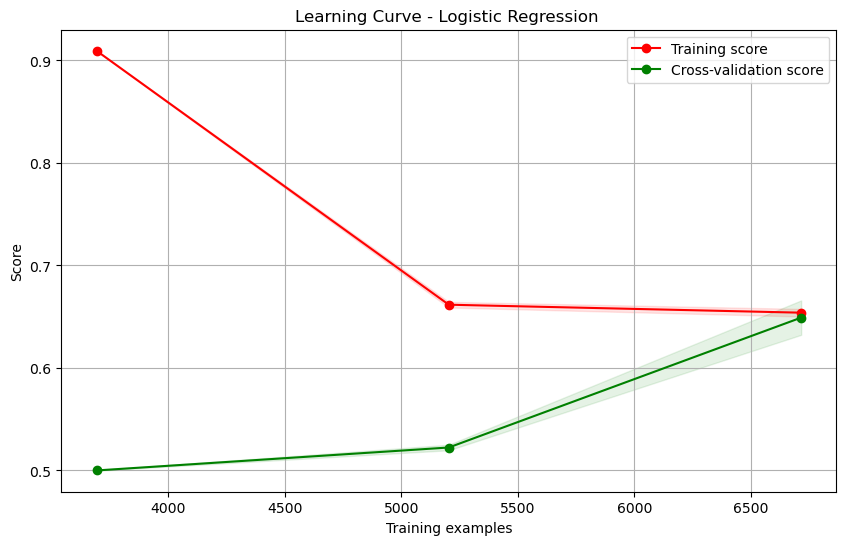

In [10]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


plot_learning_curve(best_model_log_reg_under_sample, "Learning Curve - Logistic Regression ", X_train_under_sampled_1, y_train_under_sampled_1, cv=5, n_jobs=-1)
plt.show()

In [11]:
rus_5 = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # roughly a 2:1 ratio of class 0 to class 1 instances
X_train_under_sampled_5, y_train_under_sampled_5 = rus_5.fit_resample(X_train, y_train)
# Count the number of instances of each class after undersampling

print("Original class distribution:")
print("Class 0 count:", np.sum(y_train == 0))
print("Class 1 count:", np.sum(y_train == 1))

print("\nClass distribution after undersampling:")
print("Class 0 count:", len(X_train_under_sampled_5[y_train_under_sampled_5 == 0]))
print("Class 1 count:", len(y_train_under_sampled_5[y_train_under_sampled_5 == 1]))

Original class distribution:
Class 0 count: 31970
Class 1 count: 4198

Class distribution after undersampling:
Class 0 count: 8396
Class 1 count: 4198


In [12]:
logreg_2 = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],     
    'penalty': ['l1','l2'],                  
    'solver': ['liblinear'],   
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    logreg_2,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the undersampled data
grid_search.fit(X_train_under_sampled_5, y_train_under_sampled_5)

# Get the best estimator from the grid search
best_model_log_reg_under_sample_5 = grid_search.best_estimator_
best_param_log_reg_under_sample_5 = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_5 = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_5 = cross_val_recall_scores_5.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_5 = best_model_log_reg_under_sample_5.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_model_log_reg_under_sample_5)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_5)

# Print classification report
print(classification_report(y_test, y_pred_5))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: LogisticRegression(C=0.1, solver='liblinear')
Average Recall from Cross-Validation: 0.2551180543731199
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7952
           1       0.50      0.25      0.33      1091

    accuracy                           0.88      9043
   macro avg       0.70      0.61      0.63      9043
weighted avg       0.85      0.88      0.86      9043



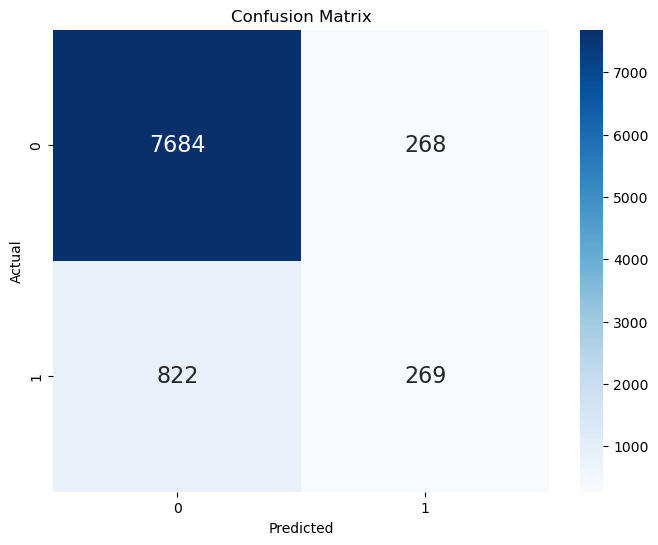

In [13]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_5)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

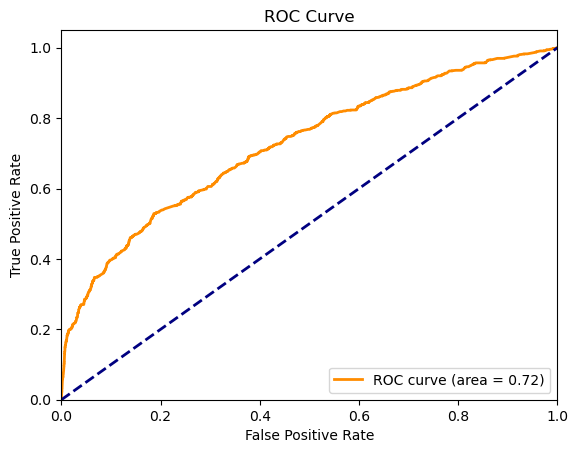

In [14]:
y_prob = best_model_log_reg_under_sample_5.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

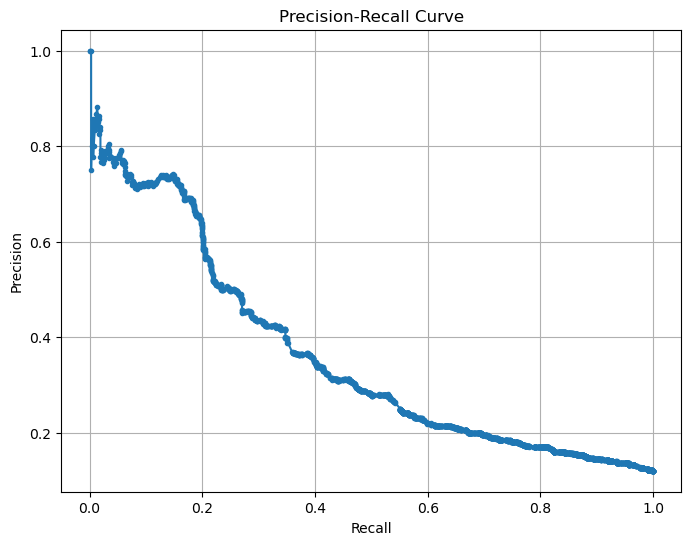

In [15]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_log_reg_under_sample_5.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

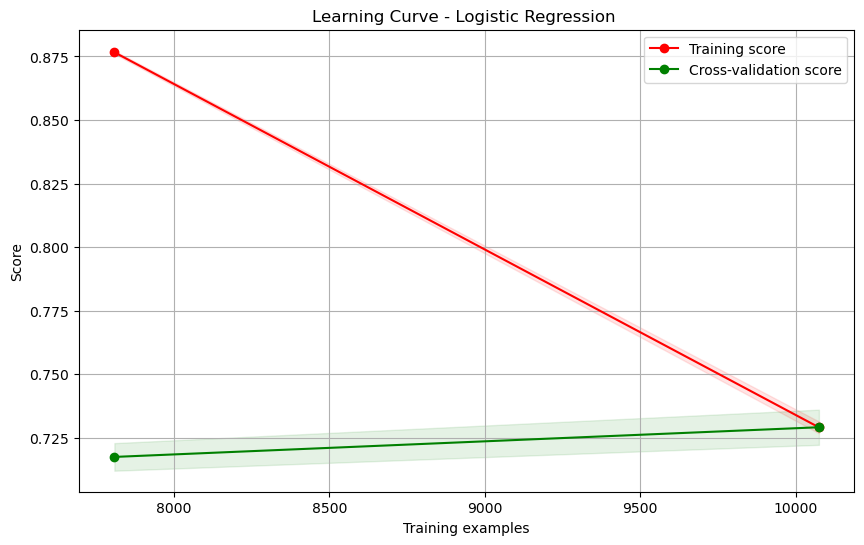

In [16]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


plot_learning_curve(best_model_log_reg_under_sample_5, "Learning Curve - Logistic Regression ", X_train_under_sampled_5, y_train_under_sampled_5, cv=5, n_jobs=-1)
plt.show()

In [17]:
# Now, lets apply oversampling
smote = SMOTE(random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:")
print("Class 0 count:", np.sum(y_train == 0))
print("Class 1 count:", np.sum(y_train == 1))

print("\nClass distribution after oversampling:")
print("Class 0 count:", len(X_train_over_sampled[y_train_over_sampled == 0]))
print("Class 1 count:", len(y_train_over_sampled[y_train_over_sampled == 1]))

Original class distribution:
Class 0 count: 31970
Class 1 count: 4198

Class distribution after oversampling:
Class 0 count: 31970
Class 1 count: 31970


In [18]:
logreg_3 = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],     
    'penalty': ['l1','l2'],                  
    'solver': ['liblinear'],   
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    logreg_3,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the over sampled data
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

# Get the best estimator from the grid search
best_model_log_reg_over_sample = grid_search.best_estimator_
best_param_log_reg_over_sample = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_3 = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_3 = cross_val_recall_scores_3.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_3 = best_model_log_reg_over_sample.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_model_log_reg_over_sample)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_3)

# Print classification report
print(classification_report(y_test, y_pred_3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
Average Recall from Cross-Validation: 0.7492336565530185
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      7952
           1       0.19      0.68      0.29      1091

    accuracy                           0.61      9043
   macro avg       0.56      0.64      0.51      9043
weighted avg       0.84      0.61      0.67      9043



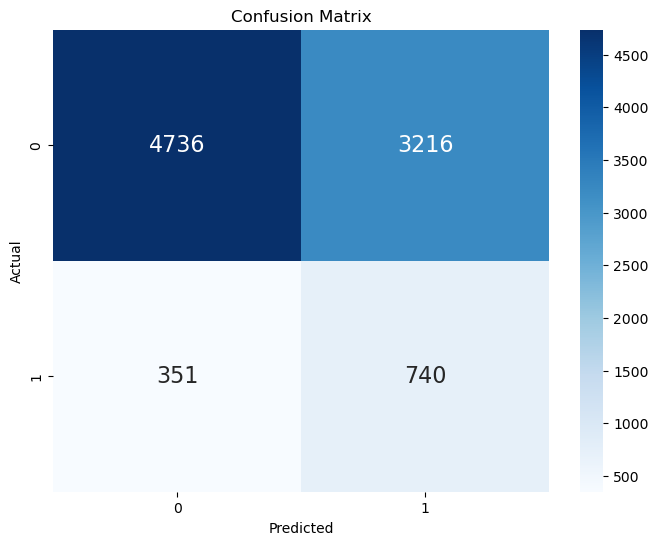

In [19]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_3)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

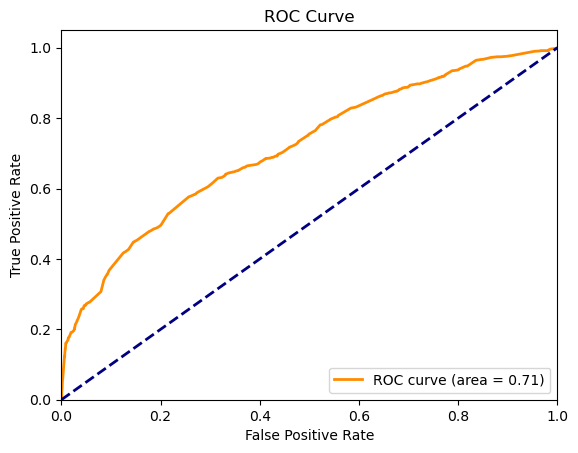

In [20]:
y_prob = best_model_log_reg_over_sample.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

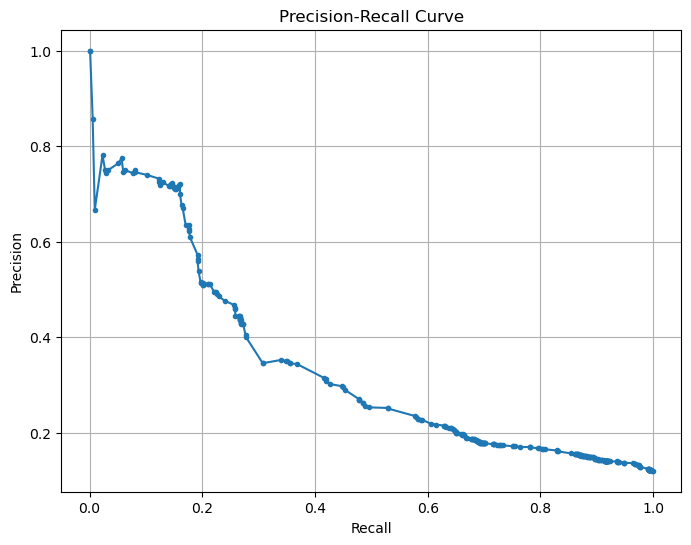

In [21]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_log_reg_over_sample.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

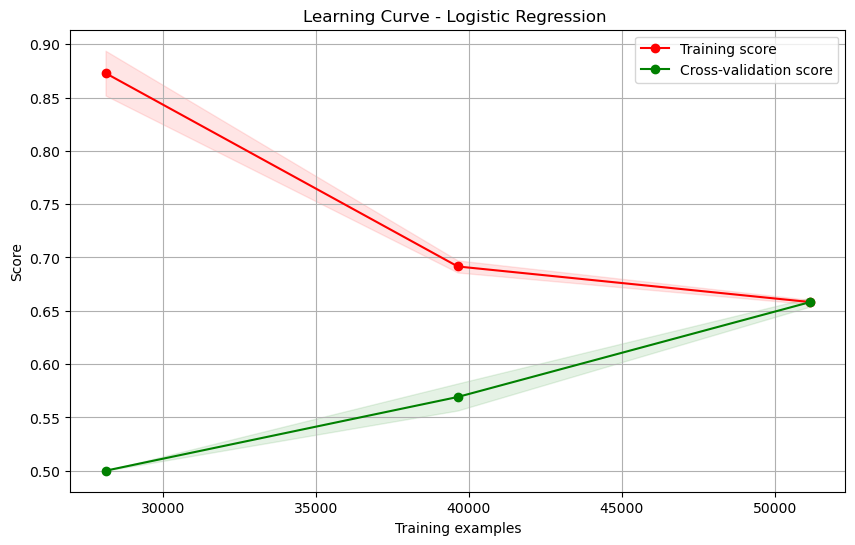

In [22]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


plot_learning_curve(best_model_log_reg_over_sample, "Learning Curve - Logistic Regression ", X_train_over_sampled, y_train_over_sampled, cv=5, n_jobs=-1)
plt.show()

In [23]:
# Define class weights based on the class distribution
class_weights = {0: 0.12, 1: 0.88}

# Create the logistic regression model with class weights
logreg_4 = LogisticRegression(class_weight=class_weights)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],     
    'penalty': ['l1','l2'],                  
    'solver': ['liblinear'],   
}

# Define the scoring metric (recall)
scorer = make_scorer(recall_score)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    logreg_4,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# Fit the grid search on the over sampled data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_model_log_reg_weights = grid_search.best_estimator_
best_param_log_reg_weights = grid_search.best_params_

# Perform cross-validation and get recall scores
cross_val_recall_scores_weight = grid_search.cv_results_['mean_test_score']

# Calculate average recall score from cross-validation
avg_recall_cross_val_weight = cross_val_recall_scores_weight.max()  # Use max because scoring is recall

# Make predictions on the test set
y_pred_4 = best_model_log_reg_weights.predict(X_test)

# Print best hyperparameters, cross-validation recall, and test recall
print("Best Hyperparameters:", best_model_log_reg_weights)
print("Average Recall from Cross-Validation:", avg_recall_cross_val_weight)

# Print classification report
print(classification_report(y_test, y_pred_4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: LogisticRegression(C=0.01, class_weight={0: 0.12, 1: 0.88}, penalty='l1',
                   solver='liblinear')
Average Recall from Cross-Validation: 0.6876987910778138
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      7952
           1       0.19      0.66      0.30      1091

    accuracy                           0.63      9043
   macro avg       0.56      0.64      0.52      9043
weighted avg       0.84      0.63      0.69      9043



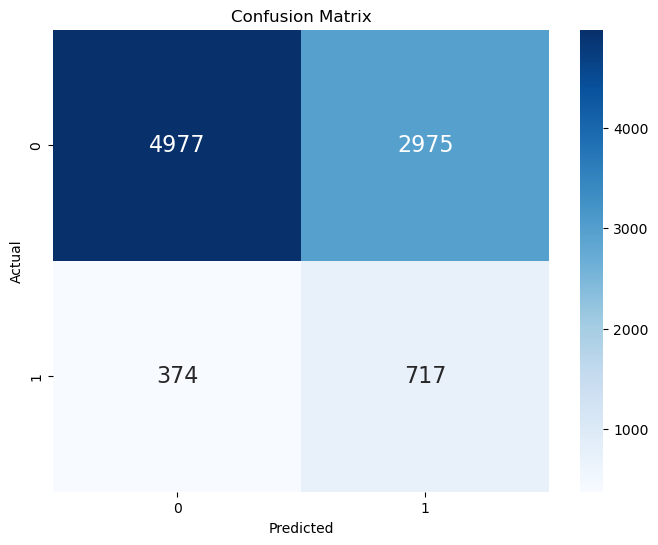

In [24]:
# lets see the confusion matrix as well.
cm = confusion_matrix(y_test, y_pred_4)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

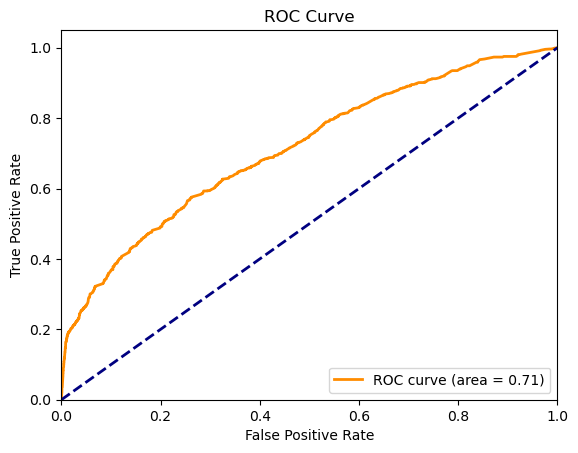

In [25]:
y_prob = best_model_log_reg_weights.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

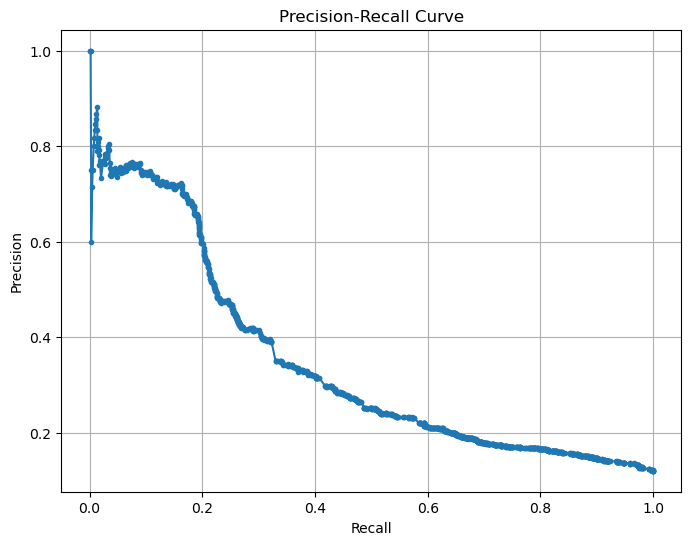

In [26]:
# Get predicted probabilities for the positive class (class 1)
y_scores = best_model_log_reg_weights.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

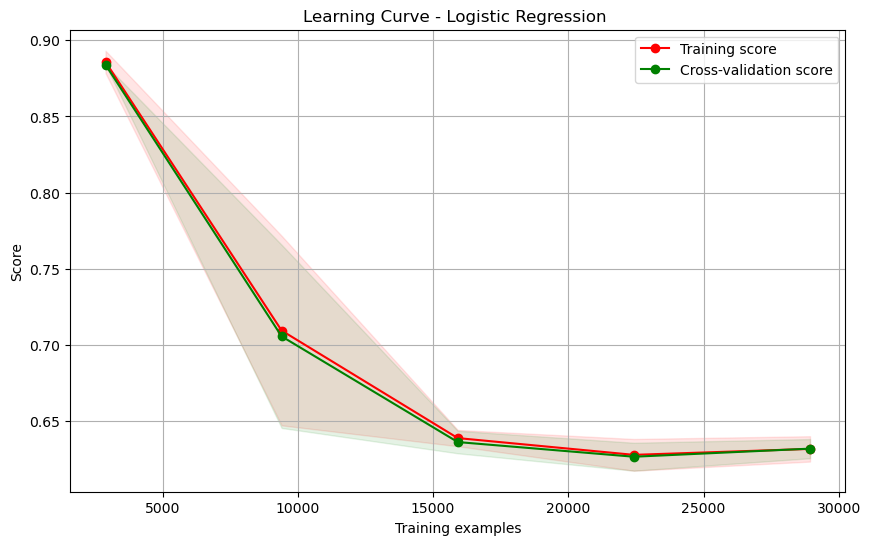

In [27]:
# lets see the learning curve of model at different folds as well to see if it overfits the data
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


plot_learning_curve(best_model_log_reg_weights, "Learning Curve - Logistic Regression ", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

In [28]:
# save the model for further investigation and usage in future
joblib.dump(best_model_log_reg_under_sample, 'best_model_log_reg_under_sample_with_1_to_1_ratio.pkl')
joblib.dump(best_model_log_reg_under_sample_5, 'best_model_log_reg_under_sample_with_2_to_1_ratio.pkl')
joblib.dump(best_model_log_reg_over_sample, 'best_model_log_reg_over_sample.pkl')
joblib.dump(best_model_log_reg_weights, 'best_model_log_reg_weight_adjustion.pkl')

['best_model_log_reg_weight_adjustion.pkl']